In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
from sklearn import metrics
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/etc/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data uploading

The data was generated form the AR(2) model of the following form $y_t=N(0,1)+0.88y_{t-1}-0.6y_{t-2}$ 

Size of the data set: t=1000

In [2]:
d1=pd.read_csv("AR_4.csv")
data=np.array(d1.x)

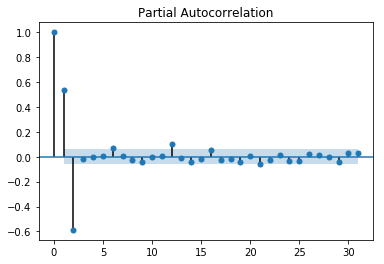

In [3]:
plot_pacf(data, lags=31)
plt.show()

# Data preparation


Arguments: 

-time_wind: length of the sequence of the historical data;

-output: how many steps ahead prediction is going to be performed;

-nb_var: number of variables of the data set;

Outputs:

-x_batches: input for the training set. Size: (899, 2, 1);

-y_batches: output for the training set. Size: (899, 1);

-x_test: inputs for the test set; Size: (96, 2, 1);

-y_test: output for the test set; Size: (96, 1);

! Note, the size of the first dimension will vary depending on the size of the time_wind. The second dimension refers to the time_wind size, thisrd dimension: number of variables;


In [2]:
def data_preparation(data,time_wind=2,output=1,nb_var=1,batch_size=1):
    data_train=data[:901]
    x_train=[]
    for i in range((len(data_train)-1)-(time_wind-1)):
        x_train.append(data_train[i:(i+time_wind)])
    x_train=np.array(x_train)
    x_batches=(x_train[:(len(x_train)-(len(x_train)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_train=data_train[time_wind:len(data_train)]
    y_batches=(y_train[:(len(y_train)-(len(y_train)%batch_size))]).reshape(-1,output)
    data_test=data[902:]
    x_t=[]
    for i in range((len(data_test)-1)-(time_wind-1)):
        x_t.append(data_test[i:(i+time_wind)])
    x_t=np.array(x_t)
    x_test=(x_t[:(len(x_t)-(len(x_t)%batch_size))]).reshape(-1,time_wind,nb_var)
    y_t=data_test[time_wind:len(data_test)]
    y_test=(y_t[:(len(y_t)-(len(y_t)%batch_size))]).reshape(-1,output)
    return x_batches, y_batches, x_test, y_test

# TensorFlow graph
Arguments:

-epochs: how many times the network is going to be trained;

-time_wind: the length of the historical sequence;

-hidden: number of hidden layers;

-nb_var: amount of input variables;

-output: how many steps ahead prediction is going to be performed;

-lr: learning rate.

Outputs:

-mse_test: the mean squared error for the final prediction vector;

-y_pred: the vector of predictions.

In [3]:
def run_graph(epochs,time_wind,hidden=10,nb_var=1,output=1,lr=0.01,r_s=1):

    from tensorflow.contrib import rnn
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,time_wind,nb_var])
    Y=tf.placeholder(tf.float32,[None,output])
 
    tf.set_random_seed(r_s)
    x=tf.unstack(X,time_wind,1)
    
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden)
    rnn_output, states=rnn.static_rnn(basic_cell,x,dtype=tf.float32)

    stacked_rnn_output=tf.reshape(rnn_output[-1],[-1,hidden])
    stacked_outputs=tf.layers.dense(stacked_rnn_output,output)
    loss=tf.reduce_mean(tf.squared_difference(stacked_outputs, Y))
    optimizer=tf.train.AdamOptimizer(learning_rate=lr)
    training_op=optimizer.minimize(loss)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for ep in range(epochs):
            sess.run(training_op,feed_dict={X: x_batches, Y: y_batches})
            if ep % 1000 == 0:
                mse=loss.eval(feed_dict={X: x_batches, Y: y_batches})
                print(ep,"\tMSE:",mse)
        y_pred=sess.run(stacked_outputs,feed_dict={X:x_test})
        mse_test=loss.eval(feed_dict={X:x_test,Y:y_test})
        print(mse)
        print(mse_test)
    sess.close() 
    return mse_test, y_pred

# Visualisation

In [4]:
def visualisation():
    plt.plot(y_test,label='Actual')
    plt.plot(y_pred,label='Forecast')
    plt.legend(loc="upper left")
    return plt.show

# Experiments

## Naive models

### Average naive model

In [9]:
x_batches, y_batches, x_test, y_test=data_preparation(data,1)
print(metrics.mean_squared_error(x_batches[:,0],np.full(len(x_batches),np.mean(x_batches))))

2.22354526527


### Constant naive model


In [10]:
x_t1=y_test[:96]
x_t=y_test[1:]
print(metrics.mean_squared_error(x_t,x_t1))

2.41235266281


# Time_wind
The aim of the first  experiment is to define the optimal size of the time_wind

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1,9,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,j)
        mse_test,y_pred=run_graph(1000,j,hidden=1,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with time_wind={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with time_wind={} equals{}".format(j, np.var(mse)))
visualisation()

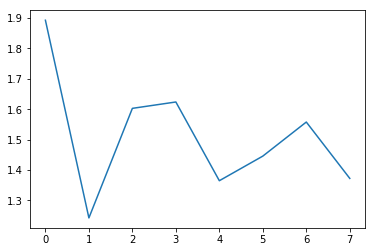

In [14]:
plt.plot(mse_mean)

Summary: The lowest mse is achieved with time_wind=2. MSE=1.2424302. Results s expactable as data is generated from the AR(2) model

# Hidden layers
The aim of the second experiment is to discover wether the increment of the number of hidden layers will improve the accuracy

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1,11,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(1000,2,hidden=j,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with hidden={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with hidden={} equals{}".format(j, np.var(mse)))
visualisation()

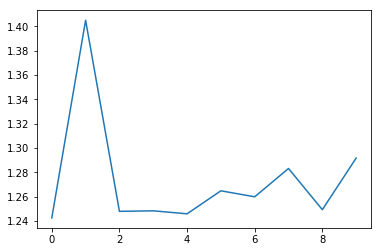

In [19]:
plt.plot(mse_mean)

Summary: The is no reason to increase the size of the hidden layer

# Optimisation of the training time
## Learning rate: 0.1

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

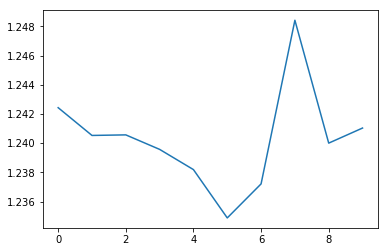

In [23]:
plt.plot(mse_mean)

Summary With the learning rate equal to 0.1, the lowest MSE is achieved with 6000 training epochs. MSE=1.234877,

## Learning rate=0.01

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.01,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

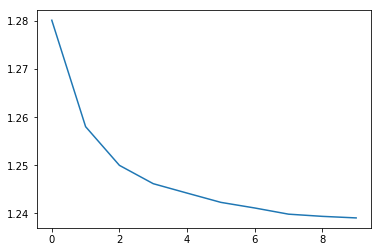

In [26]:
plt.plot(mse_mean)

Summary: with the lr=0.01 the best accuracy is achieved after 10000 training epochs. MSE= 1.2390449. As it was the lats tested value, the new experiment on the next range if values should be held

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(11000,20000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.01,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

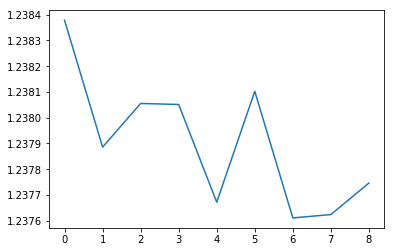

In [34]:
plt.plot(mse_mean)

Summary: with the learning rate=0.01, the highest accuracy is achieved after the 17000 training epochs. MSE=1.2376111

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(15000,21000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.001,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

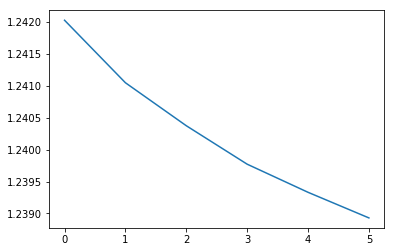

In [37]:
plt.plot(mse_mean)

Summary With the learning rate equal to 0.001, the highest accuracy is achieved after the 20000 training epochs. MSE=1.23892. It was the last tested value, so we need one more experiment.

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(20000,28000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.001,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

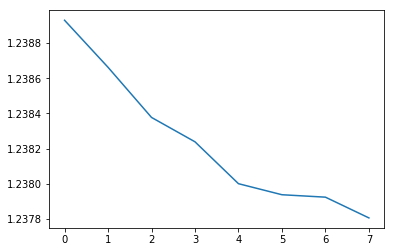

In [40]:
plt.plot(mse_mean)

Summary: Now, the highest obtained accuracy equals 1.2378058. It is achieved after 27000 training epochs. As this value is the last tested again, the new experiment is needed.

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(28000,35000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data,2)
        mse_test,y_pred=run_graph(j,2,hidden=1,lr=0.001,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

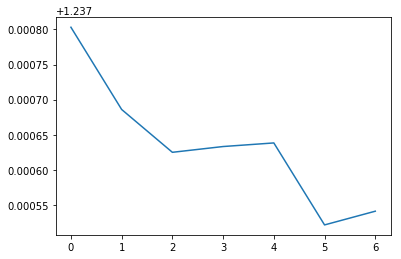

In [43]:
plt.plot(mse_mean)

Summary: with the learning rate=0.01, the lowest MSE is acheived after 33000 training epochs. MSE=1.2375214

# AR (3)
# Data uploading

The data was generated form the AR(3) model of the following form $y_t=N(0,1)+0.88y_{t-1}-0.8y_{t-2}+0.55y_{t-3}$ 

Size of the data set: t=1000

In [5]:
d3=pd.read_csv("AR_3.csv")
data3=np.array(d3.x)

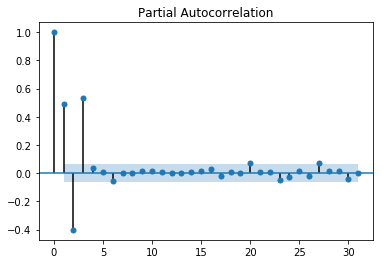

In [6]:
plot_pacf(data3, lags=31)
plt.show()

# Naive models
### Average naive model

In [17]:
x_batches, y_batches, x_test, y_test=data_preparation(data3,1)
print(metrics.mean_squared_error(x_batches[:,0],np.full(len(x_batches),np.mean(x_batches))))

1.99564265448


### Constant naive model

In [18]:
x_t1=y_test[:96]
x_t=y_test[1:]
print(metrics.mean_squared_error(x_t,x_t1))

1.87867822948


# Time_wind

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1,9,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,j)
        mse_test,y_pred=run_graph(1000,j,hidden=1,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with time_wind={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with time_wind={} equals{}".format(j, np.var(mse)))
visualisation()

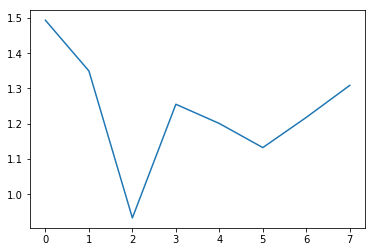

In [22]:
plt.plot(mse_mean)

Summary: The lowest MSE is achieved with the time_wind=3. What is according to our expectations. MSE=0.93301

# Hidden units

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1,11,1):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,3)
        mse_test,y_pred=run_graph(1000,3,hidden=j,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with hidden={} equals{}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with hidden={} equals{}".format(j, np.var(mse)))
visualisation()

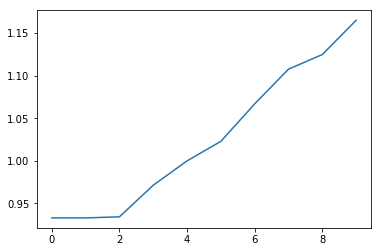

In [25]:
plt.plot(mse_mean)

Summary: The highest accuarcy is achieved with the hidden state of size hidden=2. MSE=0.933014.

## Learning rate=0.1

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(1000,11000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,3)
        mse_test,y_pred=run_graph(j,3,hidden=2,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

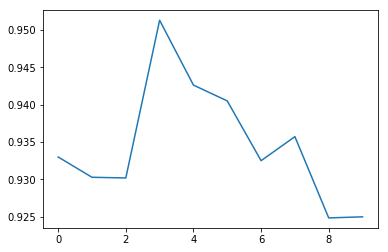

In [10]:
plt.plot(mse_mean)

Summary: the second experiment is needed

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(11000,20000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,3)
        mse_test,y_pred=run_graph(j,3,hidden=2,lr=0.1,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

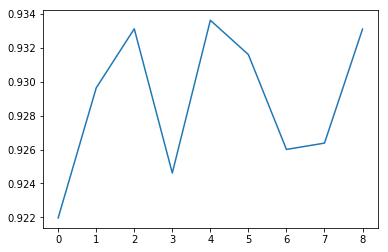

In [12]:
plt.plot(mse_mean)

Summary: highest accuracy is achieved after 11000 training epochs. An MSE=0.92196405

# Learning rate=0.01

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(5000,15000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,3)
        mse_test,y_pred=run_graph(j,3,hidden=2,lr=0.01,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

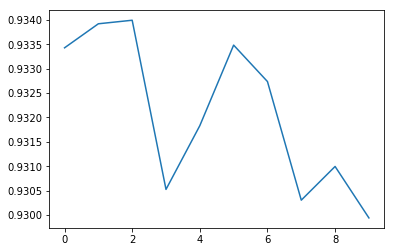

In [15]:
plt.plot(mse_mean)

In [ ]:
mse_mean=[]
mse_var=[]
for j in range(15000,25000,1000):
    mse=[]
    for i in range (10):
        x_batches, y_batches, x_test, y_test=data_preparation(data3,3)
        mse_test,y_pred=run_graph(j,3,hidden=2,lr=0.01,r_s=i)
        mse.append(mse_test)
    mse_mean.append(np.mean(mse))
    mse_var.append(np.var(mse))
    print("Mean of MSE for the model with epochs={} equals {}".format(j, np.mean(mse)))
    print("Variance of MSE for the model with epochs={} equals {}".format(j, np.var(mse)))
visualisation()

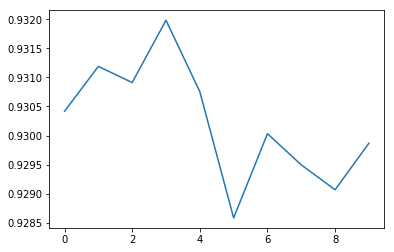

In [18]:
plt.plot(mse_mean)

Summary: The highest accuracy is achieved after 20000 iteration. MSE=0.92858344